In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from matplotlib import cm
import matplotlib.image as mpimg
%matplotlib inline
import scipy.optimize
import numpy as np

In [2]:
data = pd.read_csv('data/SR-EELS_Charakterisierung_Train-Test.csv')

colors = plt.get_cmap('Vega20', lut=len(data))

Geradengleichung: f(y) = 0.07 * y + 1901


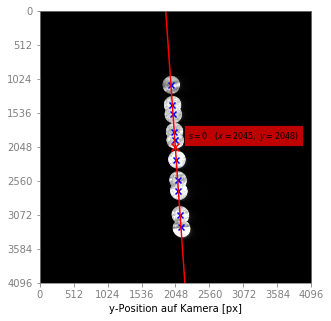

In [3]:
x_pos = data['x-pos']
y_pos = data['y-pos']

lin_func = lambda y, m, b: m * y + b
popt, pcov = scipy.optimize.curve_fit(lin_func, y_pos, x_pos, p0=(1, 0))
print('Geradengleichung: f(y) = %.2f * y + %.0f' % (*popt,))
y_fit = np.linspace(0, 4096, 1000)
x_fit = [lin_func(y, *popt) for y in y_fit]

img = mpimg.imread('data/SR-EELS_Blenden-Superposition_Train-Test.png')

plt.figure(figsize=(5, 5))
plt.grid()
plt.xlabel('x-Position auf Kamera [px]')
plt.xlabel('y-Position auf Kamera [px]')
plt.xticks(range(0, 4097, 512))
plt.yticks(range(0, 4097, 512))
plt.imshow(img, cmap='gray')
plt.scatter(x_pos, y_pos, marker='x', c='blue')
plt.plot(x_fit, y_fit, c='red')
# Für die folgende Auswertung wird der Punkt ``s=0`` auf der Geraden definiert.
plt.scatter(lin_func(2048, *popt), 2048, marker='x', c='r', s=64, linewidths=2)
plt.text(lin_func(2048, *popt) + 192,
         2048 - 128,
         '$s=0\quad (x=%d,\ y=2048)$' % lin_func(2048, *popt),
         fontsize=8,
         bbox=dict(facecolor='red', alpha=0.75)
        )
plt.xlim(0, 4096)
plt.ylim(4096, 0)
''' Würde ich kein Hintergrundbild nutzen, dann müsste ich die y-Achse selber invertieren:
limit = plt.ylim()
plt.ylim(limit[1], limit[0])
plt.xlim(limit)
'''

plt.savefig('Bilder/SR-EELS_Train-Test_Blenden-Pos')
plt.show()

In [4]:
bogen_func = lambda x, m, b: np.sqrt(1 + m**2)*x
s_0 = bogen_func(2048, *popt)
s = lambda x: bogen_func(x, *popt) -s_0 + 2048
s_pos = [s(y) for y in y_pos]
def offset_pos(pos_list):
    return [pos - 2048 for pos in pos_list]

Geradengleichung: f(y) = 0.461 * y + 1258


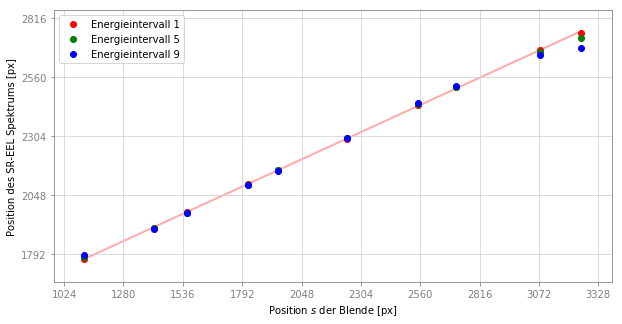

In [5]:
pos10 = data.pos10
pos50 = data.pos50
pos90 = data.pos90

popt, pcov = scipy.optimize.curve_fit(lin_func, s_pos, pos10, p0=(1, 0))
x_fit = np.linspace(np.min(s_pos), np.max(s_pos), 1000)
y_fit = [lin_func(x, *popt) for x in x_fit]
print('Geradengleichung: f(y) = %.3f * y + %.0f' % (*popt,))

plt.figure(figsize=(10, 5))
plt.xticks(range(0, 4097, 256))
plt.yticks(range(0, 4097, 256))
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Position des SR-EEL Spektrums [px]')
plt.scatter(s_pos, pos10, c='r', edgecolor='r', label='Energieintervall 1')
plt.scatter(s_pos, pos50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(s_pos, pos90, c='b', edgecolor='b', label='Energieintervall 9')
fit_line = plt.plot(x_fit, y_fit, c='r', linewidth=2, zorder=-1, alpha=0.33)
plt.legend(loc='best')
plt.savefig('Bilder/SR-EELS_Train-Test_Pos-vs-s')
plt.show()

pos10_diff = [abs(val - lin_func(x, *popt)) for val, x in zip(pos10, s_pos)]

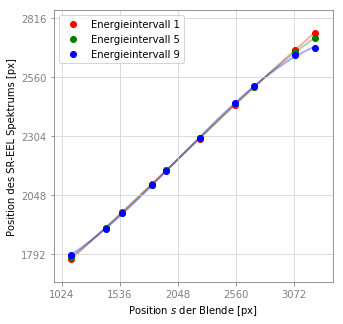

In [6]:
poly3_func = lambda x, a, b, c, d: a*x**3 + b*x**2 + c*x + d

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.yticks(range(0, 4097, 256))
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Position des SR-EEL Spektrums [px]')
for y_data, i, c in zip([pos10, pos50, pos90], [1, 5, 9], ['r', 'g', 'b']):
    label = 'Energieintervall %d' % (i,)
    plt.scatter(s_pos, y_data, c=c, edgecolor=c, label=label)
    popt, pcov = scipy.optimize.curve_fit(poly3_func, s_pos, y_data, p0=(1, 1, 1, 1))
    x_fit = np.linspace(np.min(s_pos), np.max(s_pos), 1000)
    y_fit = [poly3_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=c, linewidth=2, zorder=-1, alpha=0.33)
plt.legend(loc='best')
# plt.savefig('Bilder/SR-EELS_Charakterisierung_Pos-vs-s_poly')
plt.show()

Die maximale Abweichung beträgt beim Polynom 3.828 px.


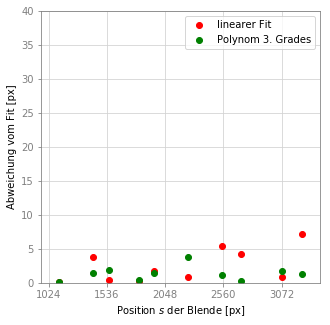

In [7]:
popt, pcov = scipy.optimize.curve_fit(poly3_func, s_pos, pos10, p0=(1, 1, 1, 1))
pos10_diff_poly = [abs(val - poly3_func(x, *popt)) for val, x in zip(pos10, s_pos)]

print('Die maximale Abweichung beträgt beim Polynom %.3f px.' % (np.max(pos10_diff_poly),))

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.ylim(0, 40)
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Abweichung vom Fit [px]')
plt.scatter(s_pos, pos10_diff, c='r', edgecolor='r', label='linearer Fit')
plt.scatter(s_pos, pos10_diff_poly, c='g', edgecolor='g', label='Polynom 3. Grades')
plt.legend(loc='best')
plt.savefig('Bilder/SR-EELS_Train-Test_Pos-vs-s_diff')
plt.show()

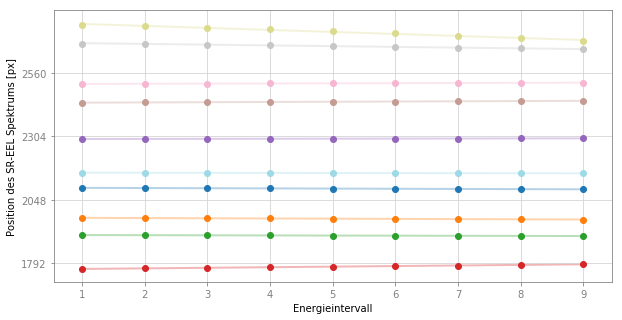

In [8]:
pos_key_list = [key for key in data.keys() if 'pos' in key and not '-pos' in key]
pos_from_keys = [int(key.replace('pos', '')) for key in pos_key_list]
#print(pos_from_keys)
data_pos = data.filter(regex=r'pos\d{2}')
def get_line(i, key_list, data):
    line = []
    for key in key_list:
        line.append(data.iloc[i,][key])
    return line
lines_pos = [get_line(i, pos_key_list, data_pos) for i in range(len(data_pos))]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(lin_func, pos_from_keys, line, p0=(1, 0))
    x_fit = np.linspace(np.min(pos_from_keys), np.max(pos_from_keys), 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Train-Test_Pos-vs-E')
plt.show()

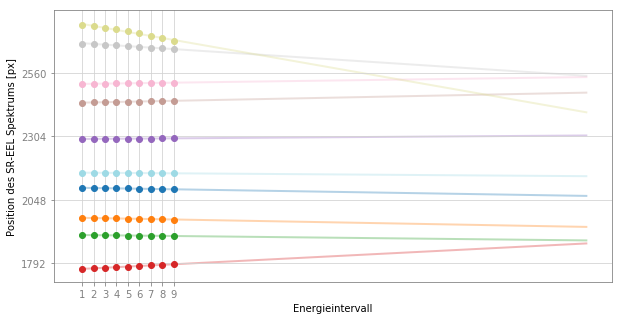

In [9]:
plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(lin_func, pos_from_keys, line, p0=(1, 0))
    x_fit = np.linspace(np.min(pos_from_keys), 5 * np.max(pos_from_keys), 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Train-Test_Pos-vs-E_p1')
plt.show()

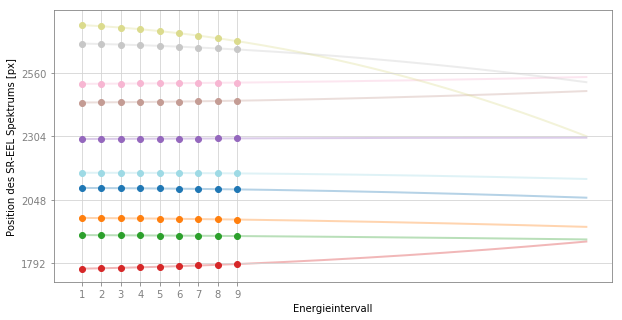

In [10]:
plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

poly2_func = lambda x, a, b, c: a + b*x + c*x**2

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(poly2_func, pos_from_keys, line, p0=(1, 1, 1))
    x_fit = np.linspace(np.min(pos_from_keys), 3 * np.max(pos_from_keys), 1000)
    y_fit = [poly2_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Train-Test_Pos-vs-E_p2')
plt.show()

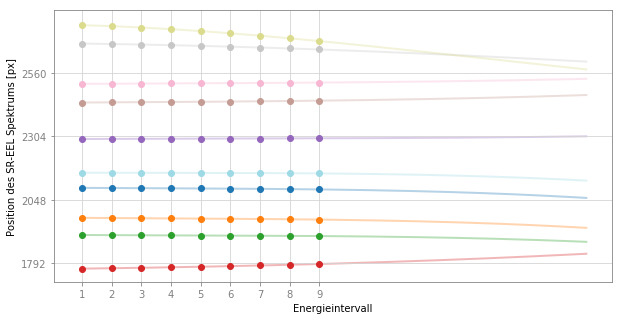

In [11]:
plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 4097, 256))
plt.xlabel('Energieintervall')
plt.ylabel('Position des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_pos):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(poly3_func, pos_from_keys, line, p0=(1, 1, 1, 1))
    x_fit = np.linspace(np.min(pos_from_keys), 2 * np.max(pos_from_keys), 1000)
    y_fit = [poly3_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Train-Test_Pos-vs-E_p3')
plt.show()

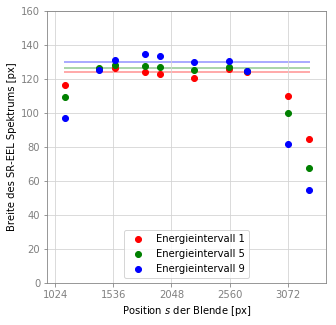

In [12]:
width10 = list(data.width10)
width50 = list(data.width50)
width90 = list(data.width90)

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.yticks(range(0, 200, 20))
plt.ylim(0, 160)
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Breite des SR-EEL Spektrums [px]')

plt.scatter(s_pos, width10, c='r', edgecolor='r', label='Energieintervall 1')
plt.scatter(s_pos, width50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(s_pos, width90, c='b', edgecolor='b', label='Energieintervall 9')

ss = []
w10s = []
w50s = []
w90s = []
p10s = []
p50s = []
p90s = []

for s, w10, w50, w90, p10, p50, p90 in zip(s_pos, width10, width50, width90, pos10, pos50, pos90):
        if w90 > 100:
            ss.append(s)
            w10s.append(w10)
            w50s.append(w50)
            w90s.append(w90)
            p10s.append(p10)
            p50s.append(p50)
            p90s.append(p90)

const_func = lambda x, a: a
for width, c in zip([w10s, w50s, w90s], ['r', 'g', 'b']):    
    popt, pcov = scipy.optimize.curve_fit(const_func, ss, width, p0=(240,))
    x_fit = np.linspace(np.min(s_pos), np.max(s_pos), 1000)
    y_fit = [const_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=c, linewidth=2, zorder=-1, alpha=0.33)

plt.legend(loc='lower center')
plt.savefig('Bilder/SR-EELS_Train-Test_Width-vs-s')
plt.show()

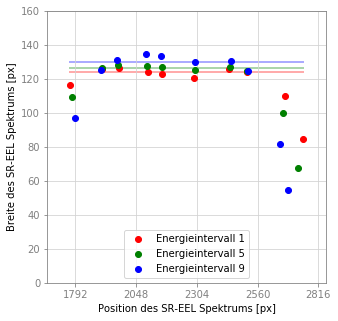

In [13]:
plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 256))
plt.yticks(range(0, 200, 20))
plt.ylim(0, 160)
plt.xlabel('Position des SR-EEL Spektrums [px]')
plt.ylabel('Breite des SR-EEL Spektrums [px]')

plt.scatter(pos10, width10, c='r', edgecolor='r', label='Energieintervall 1')
plt.scatter(pos50, width50, c='g', edgecolor='g', label='Energieintervall 5')
plt.scatter(pos90, width90, c='b', edgecolor='b', label='Energieintervall 9')

# Da die x-Werte vom Energieintervall abhängen, müssen wir zusätzlich über diese Iterieren:
for pos, width, c in zip([p10s, p50s, p90s], [w10s, w50s, w90s], ['r', 'g', 'b']):
    popt, pcov = scipy.optimize.curve_fit(const_func, pos , width, p0=(240,))
    x_fit = np.linspace(np.min(pos10), np.max(pos10), 1000)
    y_fit = [const_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=c, linewidth=2, zorder=-1, alpha=0.33)

plt.legend(loc='lower center')
plt.savefig('Bilder/SR-EELS_Train-Test_Width-vs-Pos')
plt.show()

Die Breite der korrigierten Spektren ist etwa 130 Pixel.
Rechnet man die Steigung aus dem Fit weiter oben ein, so kommt man auf etwa 282 Pixel.
Dies entspricht etwa der Blendengröße, die man aus den Abbildungen der Blende ermitteln kann.
Da bei den Abbildugen der Blende ein Demag von 0,25 verwendet wurde,
kommt man mit 4*282 = 1128 auf etwa die bekannte Blendengröße von 1060 Pixel.

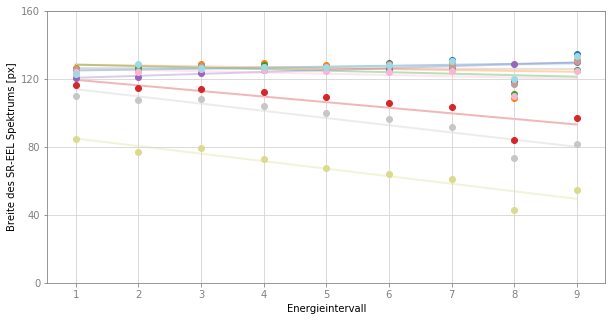

In [14]:
width_key_list = [key for key in data.keys() if 'width' in key]
pos_from_keys = [int(key.replace('width', '')) for key in width_key_list]
# Wir benötigen nur die Spalten, die die Breite enthalten:
data_width = data.filter(regex=r'width\d{2}')
lines_width = [get_line(i, width_key_list, data_width) for i in range(len(data_width))]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.yticks(range(0, 321, 40))
plt.ylim(0, 160)
plt.xlabel('Energieintervall')
plt.ylabel('Breite des SR-EEL Spektrums [px]')

for index, line, in enumerate(lines_width):
    color = colors(index)
    plt.scatter(pos_from_keys, line, c=color, edgecolor=color)
    popt, pcov = scipy.optimize.curve_fit(lin_func, pos_from_keys , line, p0=(-1, 1))
    x_fit = np.linspace(np.min(pos_from_keys), np.max(pos_from_keys), 1000)
    y_fit = [lin_func(x, *popt) for x in x_fit]
    plt.plot(x_fit, y_fit, c=color, linewidth=2, zorder=-1, alpha=0.33)
plt.savefig('Bilder/SR-EELS_Train-Test_Width-vs-E')
plt.show()

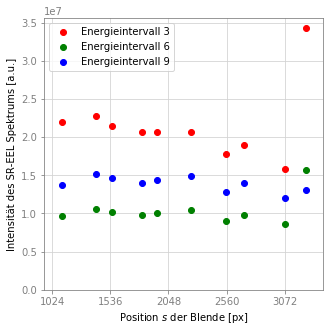

In [15]:
int30 = data.int30
int60 = data.int60
int90 = data.int90

plt.figure(figsize=(5, 5))
plt.xticks(range(0, 4097, 512))
plt.xlabel('Position $s$ der Blende [px]')
plt.ylabel('Intensität des SR-EEL Spektrums [a.u.]')

plt.scatter(s_pos, int30, c='r', edgecolor='r', label='Energieintervall 3')
plt.scatter(s_pos, int60, c='g', edgecolor='g', label='Energieintervall 6')
plt.scatter(s_pos, int90, c='b', edgecolor='b', label='Energieintervall 9')
plt.ylim(ymin=0)

plt.legend(loc='upper left')
plt.savefig('Bilder/SR-EELS_Train-Test_Int-vs-s')
plt.show()

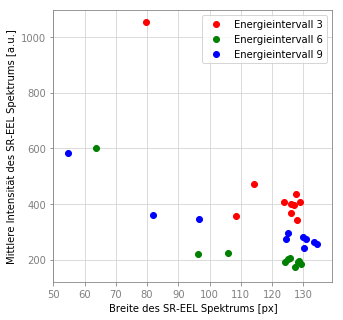

In [16]:
mean30 = data.mean30
mean60 = data.mean60
mean90 = data.mean90

plt.figure(figsize=(5, 5))
plt.xlabel('Breite des SR-EEL Spektrums [px]')
plt.ylabel('Mittlere Intensität des SR-EEL Spektrums [a.u.]')
#plt.xlim(20, 160)
#plt.ylim(0, 1000)

width30 = data.width30
width60 = data.width60
plt.scatter(width30, mean30, c='r', edgecolor='r', label='Energieintervall 3')
plt.scatter(width60, mean60, c='g', edgecolor='g', label='Energieintervall 6')
plt.scatter(width90, mean90, c='b', edgecolor='b', label='Energieintervall 9')

plt.legend(loc='best')
plt.savefig('Bilder/SR-EELS_Train-Test_Int-vs-Width')
plt.show()

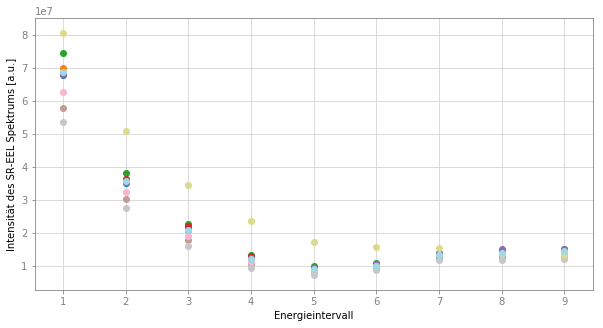

In [17]:
int_key_list = [key for key in data.keys() if 'int' in key]
int_from_keys = [int(key.replace('int', '')) for key in int_key_list]
data_int = data.filter(regex=r'int\d{2}')
lines_int = [get_line(i, int_key_list, data_int) for i in range(len(data_int))]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.xlabel('Energieintervall')
plt.ylabel('Intensität des SR-EEL Spektrums [a.u.]')

for index, line in enumerate(lines_int):
    color = colors(index)
    plt.scatter(int_from_keys, line, c=color, edgecolors=color)
plt.savefig('Bilder/SR-EELS_Train-Test_Int-vs-E')
plt.show()

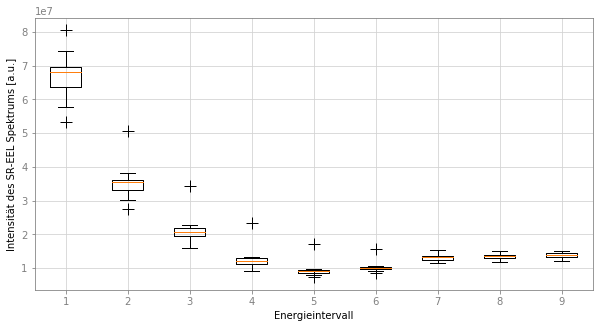

In [18]:
keys = list(data_int.keys())
keys.sort()
data_list = [data_int[key] for key in keys]

plt.figure(figsize=(10, 5))
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(10, 100, 10)
plt.xticks(xticks, ['%d' % (tick / 10,) for tick in xticks])
plt.xlabel('Energieintervall')
plt.ylabel('Intensität des SR-EEL Spektrums [a.u.]')

plt.boxplot(data_list, flierprops=dict(marker='+', markersize=12))
plt.savefig('Bilder/SR-EELS_Train-Test_Int-vs-E_Boxplot')
plt.show()

Im Notebook liegen die Punkte nicht dort, wo man sie im exportierten Bild sieht.


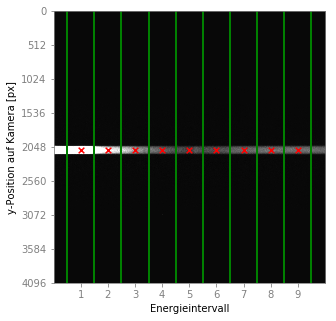

In [19]:
img = mpimg.imread('data/SR-EELS_Charakterisierung_Pos1_Train-Test.png')

plt.figure(figsize=(5, 5))
plt.grid()
# Bei den xticks verwende ich Indizes statt die Prozent-Werte:
xticks = range(409, 4090, 409)
plt.xticks(xticks, ['%d' % (tick / 409,) for tick in xticks])
plt.xlabel('Energieintervall')
plt.ylabel('y-Position auf Kamera [px]')
plt.yticks(range(0, 4097, 512))
plt.imshow(img, cmap='gray')

for i in range(1,11):
    l = mlines.Line2D([i * 409 - 409/2]*2, [0, 4095], c='g', linewidth=2)
    ax = plt.gca()
    ax.add_line(l)

# Anders als weiter oben lassen sich die Werte nicht in der Richtigen eihenfolge plotten.
# Ich muss deshalb die Listen sortieren, was zu keiner falschen Zuordnung von x- und y-Paaren führen sollte.
x_pos = [pos * 40.9 for pos in pos_from_keys]
x_pos.sort()
y_pos = [pos for pos in lines_pos[0]]
y_pos.sort()
plt.scatter(x_pos, y_pos, s=32, marker='x', c='r', linewidths=2)

plt.savefig('Bilder/SR-EELS_Train-Test_Energieintervalle')
print('Im Notebook liegen die Punkte nicht dort, wo man sie im exportierten Bild sieht.')
plt.show()

In [20]:
data.filter(regex='pos')

,x-pos,y-pos,pos20,pos40,pos60,pos80,pos10,pos30,pos50,pos70,pos90
0,2029.287,1817.804,2095.636,2094.230,2093.017,2091.510,2096.092,2094.934,2093.713,2092.146,2089.778
1,2010.210,1556.561,1974.616,1972.915,1971.662,1969.809,1975.251,1973.743,1972.260,1970.626,1968.263
2,1999.689,1414.369,1905.701,1904.695,1903.802,1903.136,1906.107,1905.025,1904.124,1903.155,1901.787
3,1978.788,1112.751,1772.268,1775.917,1780.786,1785.850,1770.485,1773.935,1778.170,1783.361,1789.344
4,2062.839,2245.244,2293.492,2294.287,2294.815,2295.492,2293.180,2293.957,2294.671,2295.063,2295.808
5,2082.077,2549.437,2440.798,2442.361,2443.961,2446.262,2440.199,2441.476,2443.202,2445.090,2447.619
6,2091.194,2714.730,2515.859,2517.041,2518.105,2519.653,2515.441,2516.369,2517.725,2518.800,2520.525
7,2115.707,3073.586,2675.919,2671.581,2665.364,2658.191,2677.996,2673.897,2668.818,2661.798,2654.049
8,2130.122,3251.504,2748.165,2736.151,2719.451,2698.706,2752.196,2741.705,2728.703,2709.325,2688.181
9,2039.081,1945.973,2156.848,2156.806,2156.131,2155.818,2157.425,2156.946,2156.467,2155.480,2154.250
